In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/AirPassengers.csv', index_col='Month', parse_dates=True)
df.index.freq='MS'

In [3]:
df = df[-48:]
df.head()

,#Passengers
Month,
1957-01-01,315
1957-02-01,301
1957-03-01,356
1957-04-01,348
1957-05-01,355


<AxesSubplot:xlabel='Month'>

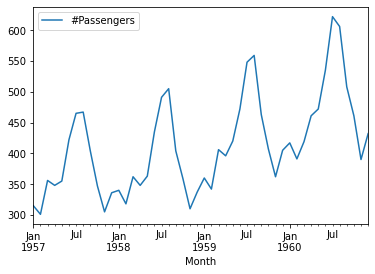

In [4]:
df.plot()

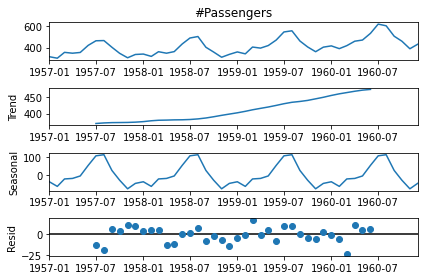

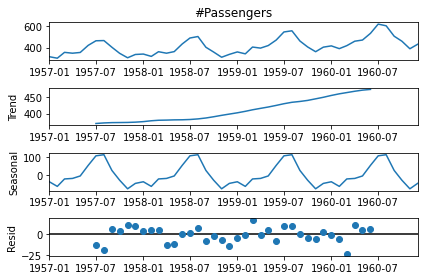

In [5]:
results = seasonal_decompose(df['#Passengers'])
results.plot()

In [6]:
len(df)

48

In [7]:
train = df.iloc[:36]
test = df.iloc[36:]

scaler = MinMaxScaler()

In [8]:
df.head(), df.tail()

(            #Passengers
 Month                  
 1957-01-01          315
 1957-02-01          301
 1957-03-01          356
 1957-04-01          348
 1957-05-01          355,
             #Passengers
 Month                  
 1960-08-01          606
 1960-09-01          508
 1960-10-01          461
 1960-11-01          390
 1960-12-01          432)

In [9]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.05426357],
       [0.        ],
       [0.21317829],
       [0.18217054],
       [0.20930233],
       [0.46899225],
       [0.63565891],
       [0.64341085],
       [0.39922481],
       [0.17829457]])

# Recursive Strategy

In [10]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.05426357],
         [0.        ],
         [0.21317829],
         [0.18217054],
         [0.20930233],
         [0.46899225],
         [0.63565891],
         [0.64341085],
         [0.39922481],
         [0.17829457],
         [0.01550388],
         [0.13565891]]]),
 array([[0.15116279]]))

In [11]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(generator, epochs=50, verbose=0)

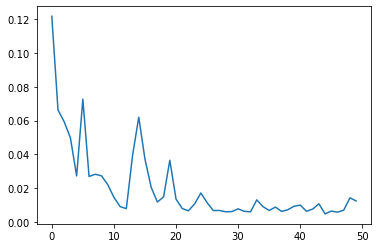

In [13]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [14]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.435017]], dtype=float32)

In [15]:
scaled_test[0], scaled_test[1]

(array([0.4496124]), array([0.34883721]))

In [16]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.435017], dtype=float32),
 array([0.47054756], dtype=float32),
 array([0.6907958], dtype=float32),
 array([0.7594297], dtype=float32),
 array([0.95769876], dtype=float32),
 array([1.2927395], dtype=float32),
 array([1.6593106], dtype=float32),
 array([1.812699], dtype=float32),
 array([1.428835], dtype=float32),
 array([1.1042731], dtype=float32),
 array([0.91484994], dtype=float32),
 array([1.040353], dtype=float32)]

In [17]:
test.head()

,#Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472


In [18]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

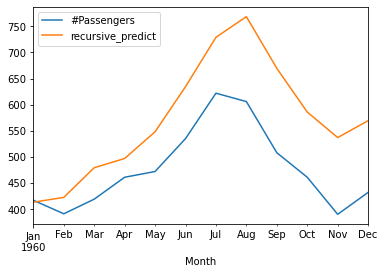

In [19]:
test.plot()

In [20]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['recursive_predict']))
print(rmse)

108.6951267227455


In [21]:
test

,#Passengers,recursive_predict
Month,,
1960-01-01,417,413.234383
1960-02-01,391,422.401270
1960-03-01,419,479.225311
1960-04-01,461,496.932861
1960-05-01,472,548.086281
1960-06-01,535,634.526794
1960-07-01,622,729.102129
1960-08-01,606,768.676332
1960-09-01,508,669.639439


# Direct Startegy

In [22]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [23]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [24]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.4488917], dtype=float32),
 array([0.4358464], dtype=float32),
 array([0.6161586], dtype=float32),
 array([0.7354874], dtype=float32),
 array([0.717743], dtype=float32),
 array([0.6673959], dtype=float32),
 array([0.7389755], dtype=float32),
 array([0.681305], dtype=float32),
 array([0.66790164], dtype=float32),
 array([0.60879785], dtype=float32),
 array([0.5485398], dtype=float32),
 array([0.57587916], dtype=float32)]

In [25]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

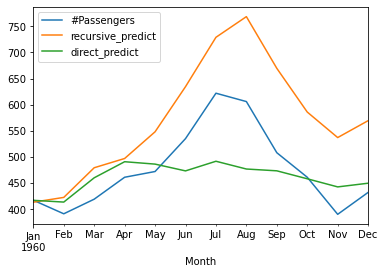

In [26]:
test.plot()

In [27]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['direct_predict']))
print(rmse)

61.275920533062006


In [28]:
test

,#Passengers,recursive_predict,direct_predict
Month,,,
1960-01-01,417,413.234383,416.814058
1960-02-01,391,422.401270,413.448368
1960-03-01,419,479.225311,459.968920
1960-04-01,461,496.932861,490.755750
1960-05-01,472,548.086281,486.177689
1960-06-01,535,634.526794,473.188140
1960-07-01,622,729.102129,491.655685
1960-08-01,606,768.676332,476.776688
1960-09-01,508,669.639439,473.318622


# Direct Recursive Startegy

In [29]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [30]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [31]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.42998502], dtype=float32),
 array([0.4802694], dtype=float32),
 array([0.6036982], dtype=float32),
 array([0.58293325], dtype=float32),
 array([0.589501], dtype=float32),
 array([0.5782435], dtype=float32),
 array([0.5772178], dtype=float32),
 array([0.5630582], dtype=float32),
 array([0.54072064], dtype=float32),
 array([0.54573816], dtype=float32),
 array([0.57804626], dtype=float32),
 array([0.6278367], dtype=float32)]

In [32]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

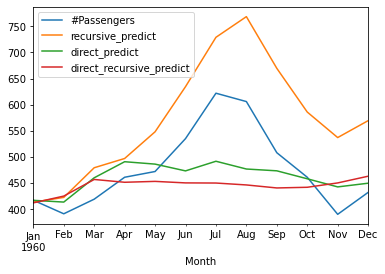

In [33]:
test.plot()

In [34]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['direct_recursive_predict']))
print(rmse)

78.98784046297277


In [35]:
test

,#Passengers,recursive_predict,direct_predict,direct_recursive_predict
Month,,,,
1960-01-01,417,413.234383,416.814058,411.936134
1960-02-01,391,422.401270,413.448368,424.909506
1960-03-01,419,479.225311,459.968920,456.754134
1960-04-01,461,496.932861,490.755750,451.396778
1960-05-01,472,548.086281,486.177689,453.091264
1960-06-01,535,634.526794,473.188140,450.186821
1960-07-01,622,729.102129,491.655685,449.922197
1960-08-01,606,768.676332,476.776688,446.269015
1960-09-01,508,669.639439,473.318622,440.505926


# MIMO

In [36]:
def generate_data(data, n_input):
    X, y = [], []
    for i in range(0,len(data)-(n_input*2)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_input])
    return np.array(X), np.array(y)

In [37]:
n_input = 12
n_features = 1
X, y = generate_data(scaled_train, n_input)

In [38]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_input))
model.compile(optimizer='adam', loss='mse')

In [39]:
model.fit(X, y, epochs=50, verbose=0)

In [40]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_25 (Dense)             (None, 12)                2412      
Total params: 164,012
Trainable params: 164,012
Non-trainable params: 0
_________________________________________________________________


In [41]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [42]:
res.shape

(12, 1)

In [43]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [44]:
test

,#Passengers,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
Month,,,,,
1960-01-01,417,413.234383,416.814058,411.936134,407.707001
1960-02-01,391,422.401270,413.448368,424.909506,412.778992
1960-03-01,419,479.225311,459.968920,456.754134,403.558899
1960-04-01,461,496.932861,490.755750,451.396778,415.950500
1960-05-01,472,548.086281,486.177689,453.091264,419.343384
1960-06-01,535,634.526794,473.188140,450.186821,430.507050
1960-07-01,622,729.102129,491.655685,449.922197,437.233459
1960-08-01,606,768.676332,476.776688,446.269015,445.371338
1960-09-01,508,669.639439,473.318622,440.505926,450.625488


<AxesSubplot:xlabel='Month'>

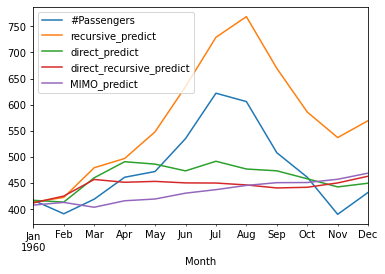

In [45]:
test.plot()

In [46]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['MIMO_predict']))
print(rmse)

84.5199258736021


# Direct MIMO

In [47]:
def generate_data(data, n_input, q_no,n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*3): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [48]:
def model_predict(train_data, n_input, n_features, q_no,n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(3))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no,n_output)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [49]:
n_input = 12
n_features = 1
test_predictions = []

n_output = 3

q = int(len(scaled_test)/n_output)


for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1,n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.51655006, 0.5599842 , 0.5168211 ]], dtype=float32),
 array([[0.7785278 , 0.74276036, 0.7676863 ]], dtype=float32),
 array([[0.7183486 , 0.69579744, 0.62296236]], dtype=float32),
 array([[0.58094835, 0.58833796, 0.56745046]], dtype=float32)]

In [50]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [51]:
res = np.array(res)
res = res.reshape((res.shape[0],1))
res.shape

(12, 1)

In [52]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [53]:
test

,#Passengers,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
Month,,,,,,
1960-01-01,417,413.234383,416.814058,411.936134,407.707001,434.269897
1960-02-01,391,422.401270,413.448368,424.909506,412.778992,445.475922
1960-03-01,419,479.225311,459.968920,456.754134,403.558899,434.339844
1960-04-01,461,496.932861,490.755750,451.396778,415.950500,501.860168
1960-05-01,472,548.086281,486.177689,453.091264,419.343384,492.632172
1960-06-01,535,634.526794,473.188140,450.186821,430.507050,499.063080
1960-07-01,622,729.102129,491.655685,449.922197,437.233459,486.333923
1960-08-01,606,768.676332,476.776688,446.269015,445.371338,480.515717
1960-09-01,508,669.639439,473.318622,440.505926,450.625488,461.724274


<AxesSubplot:xlabel='Month'>

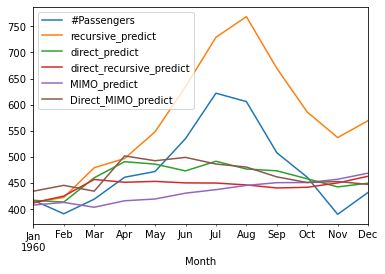

In [54]:
test.plot()

In [55]:
rmse = sqrt(mean_squared_error(test['#Passengers'], test['Direct_MIMO_predict']))
print(rmse)

62.89091335393544


In [56]:
rec_err = abs(test['#Passengers'] - test['recursive_predict'])
dir_err = abs(test['#Passengers'] - test['direct_predict'])
dir_rec_err = abs(test['#Passengers'] - test['direct_recursive_predict'])
mimo_err = abs(test['#Passengers'] - test['MIMO_predict'])
dir_mimo_err = abs(test['#Passengers'] - test['Direct_MIMO_predict'])

In [57]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [58]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
Month,,,,,
1960-01-01,3.765617,0.185942,5.063866,9.292999,17.269897
1960-02-01,31.401270,22.448368,33.909506,21.778992,54.475922
1960-03-01,60.225311,40.968920,37.754134,15.441101,15.339844
1960-04-01,35.932861,29.755750,9.603222,45.049500,40.860168
1960-05-01,76.086281,14.177689,18.908736,52.656616,20.632172
1960-06-01,99.526794,61.811860,84.813179,104.492950,35.936920
1960-07-01,107.102129,130.344315,172.077803,184.766541,135.666077
1960-08-01,162.676332,129.223312,159.730985,160.628662,125.484283
1960-09-01,161.639439,34.681378,67.494074,57.374512,46.275726


<AxesSubplot:xlabel='Month'>

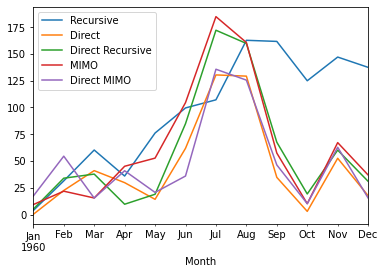

In [59]:
errors.plot()